In [61]:
import pandas as pd
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib
import random
import os
import argparse
from sklearn.metrics import precision_recall_curve
import scipy.stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import scipy.stats
import matplotlib.pyplot as plt

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42 

dnase_preds="ENCSR000EMT.DNASE.GM12878.fold.mean.scores.tsv"
atac_preds="ENCSR637XSC.ATAC.GM12878.fold.mean.scores.tsv"
atac_preds_250m="ENCSR637XSC.250M.ATAC.GM12878.fold.mean.scores.tsv"
atac_preds_100m="ENCSR637XSC.100M.ATAC.GM12878.fold.mean.scores.tsv"
atac_preds_50m="ENCSR637XSC.50M.ATAC.GM12878.fold.mean.scores.tsv"
atac_preds_25m="ENCSR637XSC.25M.ATAC.GM12878.fold.mean.scores.tsv"
atac_preds_5m="ENCSR637XSC.5M.ATAC.GM12878.fold.mean.scores.tsv"
gkm_svm = pd.read_csv("41588_2015_BFng3331_MOESM26_ESM.csv",header=0,sep=',')
print(gkm_svm.shape)
es = pd.read_csv("GSE31388_dsQtlTable.txt", sep="\t")
es.head()
es["rsid"] = es["Chr"]+"."+es["SNP"].astype(str)

### get effect sizes for positive labels

gkm_svm = gkm_svm.merge(es, left_on=["SNPname1"], right_on='rsid', how="left").drop_duplicates('SNPname1')


(28309, 18)


In [63]:
gkm_svm.columns

Index(['chrom_hg18', 'pos_hg18', 'SNPname1', 'chrom_hg19', 'pos_hg19',
       'SNPname2', 'allele1', 'allele2', 'gkm_SVM', 'kmer_SVM', 'abs_gkm_SVM',
       'abs_kmer_SVM', 'CADD', 'GWAVA_region', 'GWAVA_tss', 'GWAVA_unmatched',
       'GERP', 'label', 'Chr', 'Start', 'End', 'SNP', 'Estimate', 'Std. Error',
       't value', 'Pr(>|t|)', 'rsid'],
      dtype='object')

In [64]:
print(gkm_svm.shape)
print(es.shape)
print(sum(gkm_svm["label"]==1))

(28309, 27)
(6070, 9)
574


# Enformer pearsonr (subset to enformer set)

In [68]:
enformer_ids = pd.read_csv("enformer_predictions.tsv", sep="\t", header=0)

merged_enf_1 = enformer_ids.merge(gkm_svm, left_on=["rsid", "chr", "pos", "ref", "alt"], right_on=["SNPname2", "chrom_hg19", "pos_hg19", "allele2", "allele1"])
merged_enf_2 = enformer_ids.merge(gkm_svm, left_on=["rsid", "chr", "pos", "ref", "alt"], right_on=["SNPname2", "chrom_hg19", "pos_hg19", "allele1", "allele2"])
merged_enf_2["DNASE_SAD"] = merged_enf_2["DNASE_SAD"]*-1
merged_enf_2["DNASE_SAR"] = merged_enf_2["DNASE_SAR"]*-1

merged_enf = pd.concat([merged_enf_1, merged_enf_2]).drop_duplicates()

print(scipy.stats.pearsonr(merged_enf["DNASE_SAD"][merged_enf["label"]==1],merged_enf["Estimate"][merged_enf["label"]==1]))
print(scipy.stats.pearsonr(merged_enf["DNASE_SAR"][merged_enf["label"]==1],merged_enf["Estimate"][merged_enf["label"]==1]))

print(merged_enf["DNASE_SAD"][merged_enf["label"]==1].shape)
rsid_samples = merged_enf["rsid_x"].unique()
gkm_svm_sub = gkm_svm[gkm_svm["SNPname2"].isin(rsid_samples)]

enformer_perf = np.max([scipy.stats.pearsonr(merged_enf["DNASE_SAD"][merged_enf["label"]==1],merged_enf["Estimate"][merged_enf["label"]==1])[0],
                       scipy.stats.pearsonr(merged_enf["DNASE_SAR"][merged_enf["label"]==1],merged_enf["Estimate"][merged_enf["label"]==1])[0]])
print(enformer_perf)

(0.5549551237929846, 1.5010306000678956e-46)
(0.5631287804191751, 3.62503784193437e-48)
(560,)
0.5631287804191751


In [69]:
print(gkm_svm_sub.shape)
print(sum(gkm_svm_sub["label"]==1))

(27373, 27)
560


# DeltaSVM pearsonr

In [103]:
print(scipy.stats.pearsonr(merged_enf["gkm_SVM"][merged_enf["label"]==1],merged_enf["Estimate"][merged_enf["label"]==1]))

delta_svm_perf = scipy.stats.pearsonr(merged_enf["gkm_SVM"][merged_enf["label"]==1],merged_enf["Estimate"][merged_enf["label"]==1])[0]

print(delta_svm_perf)


(0.7318756523100427, 5.1915505043409464e-95)
0.7318756523100427


In [104]:
merged_atac.columns

Index(['chr', 'pos', 'allele1', 'allele2', 'rsid_x', 'logfc.mean',
       'abs_logfc.mean', 'abs_logfc.mean.pval', 'jsd.mean', 'jsd.mean.pval',
       'logfc_x_jsd.mean', 'log_prob_log2s.mean', 'abs_logfc_x_jsd.mean',
       'abs_logfc_x_jsd.mean.pval', 'max_percentile.mean',
       'max_percentile.mean.pval', 'logfc_x_max_percentile.mean',
       'abs_logfc_x_max_percentile.mean',
       'abs_logfc_x_max_percentile.mean.pval', 'jsd_x_max_percentile.mean',
       'jsd_x_max_percentile.mean.pval',
       'abs_logfc_x_jsd_x_max_percentile.mean',
       'abs_logfc_x_jsd_x_max_percentile.mean.pval',
       'logfc_x_jsd_x_max_percentile.mean', 'chrom_hg18', 'pos_hg18',
       'SNPname1', 'chrom_hg19', 'pos_hg19', 'SNPname2', 'gkm_SVM', 'kmer_SVM',
       'abs_gkm_SVM', 'abs_kmer_SVM', 'CADD', 'GWAVA_region', 'GWAVA_tss',
       'GWAVA_unmatched', 'GERP', 'label', 'Chr', 'Start', 'End', 'SNP',
       'Estimate', 'Std. Error', 't value', 'Pr(>|t|)', 'rsid_y'],
      dtype='object')

# ChromBPNet pearsonr

(28309, 24)
(28309, 27)


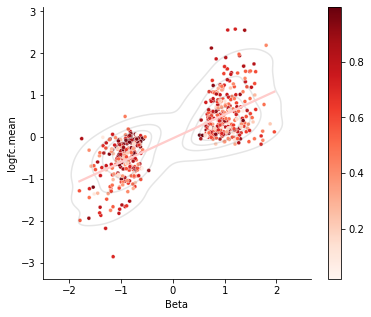

In [96]:
import seaborn as sns
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42 


dsqtls = pd.read_csv(atac_preds,sep="\t", header=0, index_col=False)
print(dsqtls.shape)
print(gkm_svm.shape)

n_gkm = gkm_svm_sub[gkm_svm_sub["label"]==1]
merged_atac = dsqtls.merge(n_gkm, left_on=['chr', 'pos', 'allele1', 'allele2'], right_on=["chrom_hg19", "pos_hg19", "allele1", "allele2"], how="inner")
    
data = pd.DataFrame()
data["logfc.mean"] = merged_atac["logfc.mean"]*-1
data["Beta"] = merged_atac["Estimate"]
data["max_percentile.mean"] = abs(merged_atac["max_percentile.mean"])
data = data.reset_index(drop=True)
#print(data.head())
plt.figure(figsize=(6,5))

sns.kdeplot(
    data=data,
    x="Beta",
    y="logfc.mean",
    levels=5,
    fill=False,
    alpha=0.2,
    color="grey",
    cut=2,

)

norm = plt.Normalize(data['max_percentile.mean'].min(), data['max_percentile.mean'].max())
sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)

ax = sns.scatterplot(x="Beta", y="logfc.mean", hue="max_percentile.mean", data=data, s=15, palette="Reds")
sns.regplot(x="Beta", y="logfc.mean", data=data, scatter=False, ci=None, color="#ffcccb")
#sns.jointplot(x=data["Beta"], y=data["sd_sign.mean"],s=0,ax=ax)

sm.set_array([])

ax.spines[["top", "right"]].set_visible(False)

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm)

# Subsampling performance - AUPRC and pearsonr

In [97]:
def fetch_auprc_new(preds, gkm_svm):
    dsqtls = pd.read_csv(preds,sep="\t", header=0, index_col=False)
    merged_atac = dsqtls.merge(gkm_svm, left_on=['chr', 'pos', 'allele1', 'allele2'], right_on=["chrom_hg19", "pos_hg19", "allele1", "allele2"], how="inner")
    merged_atac["label"] = merged_atac["label"].astype(int)
    fpr_chrombpnet, tpr_chrombpnet, _ = precision_recall_curve(merged_atac["label"], abs(merged_atac["abs_logfc_x_jsd_x_max_percentile.mean"]))
    roc_auc = metrics.average_precision_score(merged_atac["label"], abs(merged_atac["abs_logfc_x_jsd_x_max_percentile.mean"]))
    #roc_auc = metrics.average_precision_score(merged_atac["label"], abs(merged_atac["jsd.mean"]))
    print(roc_auc)
    return roc_auc
    
def fetch_pearsonr_logfc(preds, gkm_svm):
    dsqtls = pd.read_csv(preds,sep="\t", header=0, index_col=False)
    
    n_gkm = gkm_svm[gkm_svm["label"]==1]

    merged_atac = dsqtls.merge(n_gkm, left_on=['chr', 'pos', 'allele1', 'allele2'], right_on=["chrom_hg19", "pos_hg19", "allele1", "allele2"], how="inner")
    merged_atac["sign.jsd.mean"] = merged_atac["jsd.mean"]*np.sign(merged_atac["logfc.mean"])*-1
    
    pearsonr_val = scipy.stats.pearsonr(merged_atac["logfc.mean"]*-1, merged_atac["Estimate"])[0]
    print(scipy.stats.pearsonr(merged_atac["logfc.mean"]*-1, merged_atac["Estimate"]))
    return pearsonr_val

def fetch_pearsonr_jsd(preds, gkm_svm):
    dsqtls = pd.read_csv(preds,sep="\t", header=0, index_col=False)
    
    n_gkm = gkm_svm[gkm_svm["label"]==1]
    
    merged_atac = dsqtls.merge(n_gkm, left_on=['chr', 'pos', 'allele1', 'allele2'], right_on=["chrom_hg19", "pos_hg19", "allele1", "allele2"], how="inner")
    merged_atac["sign.jsd.mean"] = merged_atac["jsd.mean"]*np.sign(merged_atac["logfc.mean"])*-1
    
    pearsonr_val = scipy.stats.pearsonr(merged_atac["sign.jsd.mean"], merged_atac["Estimate"])[0]
    print(scipy.stats.pearsonr(merged_atac["sign.jsd.mean"], merged_atac["Estimate"]))
    return pearsonr_val

In [98]:

roc_500m = fetch_auprc_new(atac_preds, gkm_svm_sub)
roc_250m = fetch_auprc_new(atac_preds_250m, gkm_svm_sub)
roc_100m = fetch_auprc_new(atac_preds_100m, gkm_svm_sub)
roc_50m = fetch_auprc_new(atac_preds_50m, gkm_svm_sub)
roc_25m = fetch_auprc_new(atac_preds_25m, gkm_svm_sub)
roc_5m = fetch_auprc_new(atac_preds_5m, gkm_svm_sub)
roc_dnase = fetch_auprc_new(dnase_preds, gkm_svm_sub)


0.5382377424514815
0.5212720206135839
0.5130607361102206
0.4573954341174485
0.4172765936392213
0.289267529781573
0.40956479834375387


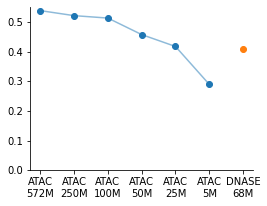

In [99]:
fix, ax = plt.subplots(figsize=(4,3))
ax.scatter(["ATAC\n572M", "ATAC\n250M", "ATAC\n100M" ,"ATAC\n50M", "ATAC\n25M", "ATAC\n5M"],[roc_500m,roc_250m,roc_100m,roc_50m,roc_25m,roc_5m])
ax.plot(["ATAC\n572M", "ATAC\n250M", "ATAC\n100M","ATAC\n50M", "ATAC\n25M", "ATAC\n5M"],[roc_500m,roc_250m,roc_100m,roc_50m,roc_25m,roc_5m], alpha=0.5)
ax.scatter(["DNASE\n68M"], [roc_dnase])
ax.set_ylim((0,0.55))
ax.spines[["top", "right"]].set_visible(False)

In [100]:

pearsonrs_logfc = []
for preds in [atac_preds, atac_preds_250m, atac_preds_100m, atac_preds_50m, atac_preds_25m, atac_preds_5m, dnase_preds]:
    pearsonrs_logfc.append(fetch_pearsonr_logfc(preds, gkm_svm_sub))

(0.7586179164294138, 6.689376032748603e-106)
(0.7526282890600602, 2.4287034191876065e-103)
(0.7546672458842387, 3.328306684572512e-104)
(0.7346524058027831, 4.429888240845516e-96)
(0.7203103315262882, 1.0646610243625364e-90)
(0.6681759905958633, 1.0998664422228002e-73)
(0.7384528353035676, 1.450001900794169e-97)


In [101]:

pearsonrs_jsd = []
for preds in [atac_preds, atac_preds_250m, atac_preds_100m, atac_preds_50m, atac_preds_25m, atac_preds_5m, dnase_preds]:
    pearsonrs_jsd.append(fetch_pearsonr_jsd(preds, gkm_svm_sub))

(0.7480524783614502, 1.959293501864504e-101)
(0.7523651296928697, 3.1344639726513044e-103)
(0.7470599652802675, 5.014684226524033e-101)
(0.736694138893397, 7.108672678159656e-97)
(0.7256926640794923, 1.1169288396490585e-92)
(0.6726748364294816, 5.1375454552778505e-75)
(0.7518146941493518, 5.338794143139969e-103)


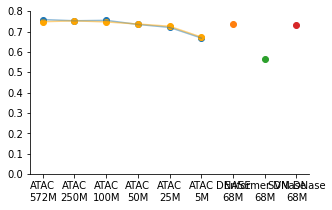

In [102]:
fig, ax = plt.subplots(figsize=(5,3))
ax.scatter(["ATAC\n572M", "ATAC\n250M", "ATAC\n100M" ,"ATAC\n50M", "ATAC\n25M", "ATAC\n5M"],pearsonrs_logfc[0:-1])
ax.plot(["ATAC\n572M", "ATAC\n250M", "ATAC\n100M","ATAC\n50M", "ATAC\n25M", "ATAC\n5M"],pearsonrs_logfc[0:-1], alpha=0.5)
ax.scatter(["ATAC\n572M", "ATAC\n250M", "ATAC\n100M" ,"ATAC\n50M", "ATAC\n25M", "ATAC\n5M"],pearsonrs_jsd[0:-1], c="orange")
ax.plot(["ATAC\n572M", "ATAC\n250M", "ATAC\n100M","ATAC\n50M", "ATAC\n25M", "ATAC\n5M"],pearsonrs_jsd[0:-1], alpha=0.5, c="orange")

ax.scatter(["DNASE\n68M"], [pearsonrs_logfc[-1]])
ax.scatter(["Enformer DNase\n68M"], [enformer_perf])
ax.scatter(["SVM DNase\n68M"], [delta_svm_perf])

ax.set_ylim((0,0.8))
ax.spines[["top", "right"]].set_visible(False)
#plt.savefig("subfigs_new/subsample_pearsonr_performance.pdf", transparent=True, dpi=300)
